In [1]:
import requests
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

In [48]:
import matplotlib.pyplot as plt

In [2]:
import time

In [3]:
def to_int(row):
    if isinstance(row,int) or isinstance(row,float):
        return row 
    tokens = row.split(' ')
    if len(tokens) ==2:
        return int(tokens[0])
    try:
        return int(row)
    except ValueError:
        return np.nan#int(row.GF.split(' ')[0])

In [4]:
def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    if agg_func == 'sum':
        rolling = df[cols].shift(1).rolling(window).sum()
    if agg_func == 'mean':
        rolling = df[cols].shift(1).rolling(window).mean()
    rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling],axis=1)
    return df_rolling

In [5]:
def get_no_of_time_opp_faced(row):
    present_date = row.Prev_match_date
    if present_date is np.nan:
        pass
    back_df = df[df.Date<=present_date]
    Opp_faced = back_df.Opponent.value_counts().to_dict()
    if row.Opponent not  in Opp_faced.keys():
        return 0
    #display(Opp_faced)
    return Opp_faced[row.Opponent]

In [6]:
def previous_month_agg(df,cols,agg_func):
    df=df.copy()
    group_df = df.groupby("Month")[cols].agg(agg_func)
    
    #cummulative in each month
    gp_arr=[]
    for g,gd in df.groupby(['Month'])[cols]:
        #print(g)
        #display(gd)
        if agg_func == 'sum':
            gd_cum = gd.shift(1).cumsum()
        if agg_func == 'mean':
            gd_cum = gd.shift(1).expanding().mean()
        for col in cols:
            gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)    
        gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    cum_cols = [col+'_this_month_'+agg_func for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    
    group_df.index = df.Month.unique() 
    group_df = group_df.shift(1)
    alias1 = '_'+agg_func+'_prev_month_'
    new_cols = [col+alias1 for col in cols]
    group_df.columns = new_cols
    
    out_df= pd.merge(df_with_cum, group_df ,left_on = 'Month',right_on=group_df.index)
    return out_df

In [7]:
def Trim_Captain(df):
    df = df.copy()
    Cap_count = df['Captain'].value_counts() #Captain
    top2 = Cap_count.index[:2]
    df['Captain_Rank'] = df.apply(lambda x : 'Cap/Vice' if x.Captain in top2 else 'other' ,axis=1)
    return df

In [8]:
def get_cum_by_col(df,grouper,grouper_name,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for g,gd in df.groupby([grouper])[cols]:
        #print(g)
        #display(gd)
        if agg_func == 'sum':
            gd_cum = gd.shift(1).cumsum()
        if agg_func == 'mean':
            gd_cum = gd.shift(1).expanding().mean()
        for col in cols:
            gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)    
        gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum

#### Dependent Variables
    For every matches  played ,the results can be Win , Draw or Loss and they are mutually exclusive

#### Table Like metrics
    This is similar to the data from the log containing the cummulative sum i.e league table
    
##### Average Like metrics
    This is similar to the data from the log containing the cummulative avg i.e league table
    
#### Venue like metric
    Some teams play better  at home than on the road ,vice versa
        
        * i.e Liverpool rarely lose at the Anfield and Manchester city at the Etihad stadium
        * Also United had a long streak of unbeaten on the road
     So we pick out Away win , Away Loss , Away Draw  , Home win , home draw and Home loss

#### rolling metrics
    We can input data like goal scored, possesion into our features because of data leakage.
    So we take rolling averages for the a specific window i.e sums or averages from the last two games,three games e.t.c
    
#### last games metric
    We look at result from previous match played.
    i.e the last opponent, previous competition , number of resting days
    
#### Played_Opp_X_times
    Maybe this doesnt count in football games .But in the basketball games where each team have the sets they run and plays
    they call.Number of times youve played an opponent is a factor when we consider familiarity
    
####  monthly metrics
    Football is a steaky sport and here we calculate GF,GA,Wins and other target variable for that month
    
#### Prev Month
    As mentioned earlier team confidence plays a key part in winning football games 
    
#### Trim Captain
    Some teams ,the captain is the enforcer e.g Zlatan, Sergio Ramos and some are cool headed i.e Leo Messi, Eden Hazard.
    Captains are the Coach within the four lines of the pitch and they infuence the decisions of their teammates.
    So we trim the captain feature to is it the Captain or Vice Captain or other player.
    
#### get_cum_by_col
    Here we get cummulative sum or average for columns like Win,Lose,Draw,GF,GA,Poss
    * Groupby  Venue
    * Groupby  Formation
    * Groupby  Opponent


In [9]:
def All_Transformation(df):
    start = time.time()
    df = df.copy()
    df['Month'] = df.Date.dt.month
    df.loc[:,'GA'] = df.GA.apply(to_int)
    df.loc[:,'GF'] = df.GF.apply(to_int)
    
    df['Win'] = df.apply(lambda x : 1 if x.Result == 'W' else 0 ,axis=1)
    df['Draw'] = df.apply(lambda x : 1 if x.Result == 'D' else 0 ,axis=1)
    df['Lose'] = df.apply(lambda x : 1 if x.Result == 'L' else 0 ,axis=1)
    
    #Table Like metrics
    df['Points'] = df.apply(lambda x : 3 if x.Result == 'W' else (1 if x.Result == 'D' else 0) ,axis=1)
    df['Total_Points'] = df.Points.shift(1).cumsum()
    df['Total_GF'] = df.GF.shift(1).cumsum()
    df['Total_GA'] = df.GA.shift(1).cumsum()
    df['Total_Win'] = df.Win.shift(1).cumsum()
    df['Total_Draw'] = df.Draw.shift(1).cumsum()
    df['Total_Loss'] = df.Lose.shift(1).cumsum()
    
    #Average Like metrics
    df['Points_Avg_for_szn'] = df.Points.shift(1).expanding().mean()
    df['GF_Avg_for_szn'] = df.GF.shift(1).expanding().mean()
    df['GA_Avg_for_szn'] = df.GA.shift(1).expanding().mean()
    df['Win_Avg_for_szn'] = df.Win.shift(1).expanding().mean()
    df['Draw_Avg_for_szn'] = df.Draw.shift(1).expanding().mean()
    df['Loss_Avg_for_szn'] = df.Lose.shift(1).expanding().mean()
    
    #Venue like metric
    df['Away_Win'] = df.apply(lambda x : 1 if x.Venue == 'Away' and x.Result == 'W' else 0 ,axis=1)
    df['Away_Draw'] = df.apply(lambda x : 1 if x.Venue == 'Away' and x.Result == 'D' else 0 ,axis=1)
    df['Away_Loss'] = df.apply(lambda x : 1 if x.Venue == 'Away' and x.Result == 'L' else 0 ,axis=1)
    df['Home_Win'] = df.apply(lambda x : 1 if x.Venue == 'Home' and x.Result == 'W' else 0 ,axis=1)
    df['Home_Draw'] = df.apply(lambda x : 1 if x.Venue == 'Home' and x.Result == 'D' else 0 ,axis=1)
    df['Home_Loss'] = df.apply(lambda x : 1 if x.Venue == 'Home' and x.Result == 'L' else 0 ,axis=1)
    
    #rolling metrics
    df = rolling_average_or_sum(df,
                                cols=['Points','Win','Draw','Lose','GF','GA',
                                      'Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],
                                window=1,agg_func='sum')
    df = rolling_average_or_sum(df,cols=['Points','Win','Draw','Lose','GF','GA',
                                         'Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],
                                window=2,agg_func='sum')
    df = rolling_average_or_sum(df,cols=['Points','Win','Draw','Lose','GF','GA',
                                         'Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss','Poss'],
                                window=3,agg_func='mean')
    #last games metric
    df['Prev_match_date'] = df.Date.shift(1)
    df['Rest'] = df.Date - df.Prev_match_date
    df['Prev_comp'] = df.Comp.shift(1)
    df['Prev_Opp'] = df.Opponent.shift(1)
    
    df.loc[:,'Played_Opp_X_times'] = df.apply( get_no_of_time_opp_faced,axis='columns')
    
    month_cols = cols = ['GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss']
    df = previous_month_agg(df,month_cols,'sum')
    df = previous_month_agg(df=df,cols=['GF','GA'],agg_func='mean')
    #display(df.head())
    df = previous_month_agg(df=df,cols=['Poss'],agg_func='mean')
    df = Trim_Captain(df)
    df = get_cum_by_col(df,grouper='Venue',grouper_name='Venue',cols=['Poss','GF','GA'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Venue',grouper_name='Venue',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    df = get_cum_by_col(df,grouper='Formation',grouper_name='Formation',cols=['Poss','GF','GA'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Formation',grouper_name='Formation',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    df = get_cum_by_col(df,grouper='Opponent',grouper_name='Opp',cols=['Poss','GA','GF'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Opponent',grouper_name='Opp',cols=['Win','Lose','Draw','GA','GF'],agg_func='sum')
    print('shape ',df.shape)
    end = time.time()
    runtime = end-start
    print('Runtime:',runtime)
    return df

In [15]:
df = pd.read_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2022Chelsea.csv",parse_dates=['Date'])

In [16]:
All_Transformation(df)

shape  (61, 249)
Runtime: 0.17253756523132324


,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum
0,0,2021-08-11,20:00,Super Cup,U

In [ ]:

['Poss_this_Opp_mean',
 'GA_this_Opp_mean',
 'GF_this_Opp_mean',
 'Win_this_Opp_sum',
 'Lose_this_Opp_sum',
 'Draw_this_Opp_sum',
 'GA_this_Opp_sum',
 'GF_this_Opp_sum']

In [11]:
folder_path = "C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/"

In [12]:
dir_list = os.listdir(folder_path)

In [13]:
dir_list

['2018Arsenal.csv',
 '2018Bournemouth.csv',
 '2018Brighton and Hove Albion.csv',
 '2018Burnley.csv',
 '2018Chelsea.csv',
 '2018Crystal Palace.csv',
 '2018Everton.csv',
 '2018Huddersfield Town.csv',
 '2018Leicester City.csv',
 '2018Liverpool.csv',
 '2018Manchester City.csv',
 '2018Manchester United.csv',
 '2018Newcastle United.csv',
 '2018Southampton.csv',
 '2018Stoke City.csv',
 '2018Swansea City.csv',
 '2018Tottenham Hotspur.csv',
 '2018Watford.csv',
 '2018West Bromwich Albion.csv',
 '2018West Ham United.csv',
 '2019Arsenal.csv',
 '2019Bournemouth.csv',
 '2019Brighton and Hove Albion.csv',
 '2019Burnley.csv',
 '2019Cardiff City.csv',
 '2019Chelsea.csv',
 '2019Crystal Palace.csv',
 '2019Everton.csv',
 '2019Fulham.csv',
 '2019Huddersfield Town.csv',
 '2019Leicester City.csv',
 '2019Liverpool.csv',
 '2019Manchester City.csv',
 '2019Manchester United.csv',
 '2019Newcastle United.csv',
 '2019Southampton.csv',
 '2019Tottenham Hotspur.csv',
 '2019Watford.csv',
 '2019West Ham United.csv',
 '2

In [14]:
team_paths = [os.path.join(folder_path,csv_file) for csv_file in dir_list ]

In [15]:
team_paths

['C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Arsenal.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Bournemouth.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Brighton and Hove Albion.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Burnley.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Chelsea.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Crystal Palace.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Everton.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Huddersfield Town.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Leicester City.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Liverpool.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Manchester City.csv',
 'C:\\Users\\user\\Solo Dolo\\EPL Analysis\\2018_2022_data/2018Manchester United.csv',
 'C:\\Users

In [19]:
df = pd.read_csv(team_paths[16],parse_dates=['Date'])

In [20]:
All_Transformation(df)

shape  (55, 249)
Runtime: 0.5338730812072754


,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum
0,0,2017-08-13,13:30,Premier Lea

In [16]:
df_arr = []

In [21]:
for team_path in team_paths:
    print("Acessing : ",team_path)
    data = pd.read_csv(team_path,parse_dates=['Date'])
    X_form_data = All_Transformation(data)
    df_arr.append(X_form_data)
    print("Done")
    print()
    print()

Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Arsenal.csv
shape  (60, 249)
Runtime: 0.48940134048461914
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Bournemouth.csv
shape  (44, 249)
Runtime: 0.4403066635131836
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Brighton and Hove Albion.csv
shape  (44, 249)
Runtime: 0.4348933696746826
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Burnley.csv
shape  (41, 249)
Runtime: 0.4129946231842041
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Chelsea.csv
shape  (59, 249)
Runtime: 0.46776413917541504
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Crystal Palace.csv
shape  (42, 249)
Runtime: 0.5429539680480957
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2018Everton.csv
shape  (51, 249)
Runtime: 0.47681427001953125
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analy

shape  (59, 249)
Runtime: 0.7261490821838379
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Arsenal.csv
shape  (58, 249)
Runtime: 0.610478401184082
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Aston Villa.csv
shape  (42, 249)
Runtime: 0.4761161804199219
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Brighton and Hove Albion.csv
shape  (44, 249)
Runtime: 0.5266156196594238
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Burnley.csv
shape  (44, 249)
Runtime: 0.5170783996582031
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Chelsea.csv
shape  (59, 249)
Runtime: 0.6012434959411621
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Crystal Palace.csv
shape  (40, 249)
Runtime: 0.469684362411499
Done


Acessing :  C:\Users\user\Solo Dolo\EPL Analysis\2018_2022_data/2021Everton.csv
shape  (46, 249)
Runtime: 0.5709784030914307
Done


In [22]:
All_team_data = pd.concat(df_arr)

In [23]:
All_team_data.shape

(4783, 249)

In [28]:
All_team_data.Team.value_counts()

Chelsea                     297
Manchester City             296
Manchester United           280
Liverpool                   279
Tottenham Hotspur           278
Arsenal                     275
Leicester City              249
West Ham United             230
Everton                     226
Southampton                 220
Brighton and Hove Albion    217
Burnley                     215
Newcastle United            211
Crystal Palace              211
Wolverhampton Wanderers     189
Watford                     171
Bournemouth                 129
Aston Villa                 129
Sheffield United             87
Norwich City                 86
Fulham                       85
Huddersfield Town            84
West Bromwich Albion         84
Leeds United                 82
Swansea City                 48
Brentford                    44
Stoke City                   41
Cardiff City                 40
Name: Team, dtype: int64

In [32]:
All_team_data[All_team_data.Comp == 'Super Cup' ]

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum
0,0,2017-08-08,20:45,Super Cup,U

In [30]:
All_team_data.Comp.value_counts()

Premier League      3800
FA Cup               305
EFL Cup              277
Champions Lg         212
Europa Lg            159
Conf Lg               16
Community Shield      10
Super Cup              4
Name: Comp, dtype: int64

In [38]:
All_team_data.columns.to_list()

['Unnamed: 0',
 'Date',
 'Time',
 'Comp',
 'Round',
 'Day',
 'Venue',
 'Result',
 'GF',
 'GA',
 'Opponent',
 'xG',
 'xGA',
 'Poss',
 'Attendance',
 'Captain',
 'Formation',
 'Referee',
 'Match Report',
 'Notes',
 'Team',
 'Standard_Gls',
 'Standard_Sh',
 'Standard_SoT',
 'Standard_SoT%',
 'Standard_G/Sh',
 'Standard_G/SoT',
 'Standard_Dist',
 'Standard_FK',
 'Standard_PK',
 'Standard_PKatt',
 'Expected_xG',
 'Expected_npxG',
 'Expected_npxG/Sh',
 'Expected_G-xG',
 'Expected_np:G-xG',
 'SCA_Types_SCA',
 'SCA_Types_PassLive',
 'SCA_Types_PassDead',
 'SCA_Types_Drib',
 'SCA_Types_Sh',
 'SCA_Types_Fld',
 'SCA_Types_Def',
 'GCA_Types_GCA',
 'GCA_Types_PassLive',
 'GCA_Types_PassDead',
 'GCA_Types_Drib',
 'GCA_Types_Sh',
 'GCA_Types_Fld',
 'GCA_Types_Def',
 'Tackles_Tkl',
 'Tackles_TklW',
 'Tackles_Def_3rd',
 'Tackles_Mid_3rd',
 'Tackles_Att_3rd',
 'Vs_Dribbles_Tkl',
 'Vs_Dribbles_Att',
 'Vs_Dribbles_Tkl%',
 'Vs_Dribbles_Past',
 'Pressures_Press',
 'Pressures_Succ',
 'Pressures_%',
 'Pressur

In [39]:
no_stats_bomb = ['Date',
 'Time',
 'Comp',
 'Round',
 'Day',
 'Venue',
 'Result',
 'GF',
 'GA',
 'Opponent',
 'xG',
 'xGA',
 'Poss',
 'Attendance',
 'Captain',
 'Formation',
 'Referee',
 'Match Report',
 'Notes',
 'Team','Season',
 'Month',
 'Win',
 'Draw',
 'Lose',
 'Points',
 'Total_Points',
 'Total_GF',
 'Total_GA',
 'Total_Win',
 'Total_Draw',
 'Total_Loss',
 'Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn',
 'Away_Win',
 'Away_Draw',
 'Away_Loss',
 'Home_Win',
 'Home_Draw',
 'Home_Loss',
 'Points_last_1gm_sum',
 'Win_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Lose_last_1gm_sum',
 'GF_last_1gm_sum',
 'GA_last_1gm_sum',
 'Away_Win_last_1gm_sum',
 'Away_Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Home_Win_last_1gm_sum',
 'Home_Draw_last_1gm_sum',
 'Home_Loss_last_1gm_sum',
 'Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum',
 'Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm_mean',
 'Away_Loss_last_3gm_mean',
 'Home_Win_last_3gm_mean',
 'Home_Draw_last_3gm_mean',
 'Home_Loss_last_3gm_mean',
 'Poss_last_3gm_mean',
 'Prev_match_date',
 'Rest',
 'Prev_comp',
 'Prev_Opp',
 'Played_Opp_X_times',
 'GF_this_month_sum',
 'GA_this_month_sum',
 'Away_Win_this_month_sum',
 'Away_Draw_this_month_sum',
 'Away_Loss_this_month_sum',
 'Home_Win_this_month_sum',
 'Home_Draw_this_month_sum',
 'Home_Loss_this_month_sum',
 'GF_sum_prev_month_',
 'GA_sum_prev_month_',
 'Away_Win_sum_prev_month_',
 'Away_Draw_sum_prev_month_',
 'Away_Loss_sum_prev_month_',
 'Home_Win_sum_prev_month_',
 'Home_Draw_sum_prev_month_',
 'Home_Loss_sum_prev_month_',
 'GF_this_month_mean',
 'GA_this_month_mean',
 'GF_mean_prev_month_',
 'GA_mean_prev_month_',
 'Poss_this_month_mean',
 'Poss_mean_prev_month_',
 'Captain_Rank',
 'Poss_this_Venue_mean',
 'GF_this_Venue_mean',
 'GA_this_Venue_mean',
 'Win_this_Venue_sum',
 'Lose_this_Venue_sum',
 'Draw_this_Venue_sum',
 'GF_this_Venue_sum',
 'GA_this_Venue_sum',
 'Poss_this_Formation_mean',
 'GF_this_Formation_mean',
 'GA_this_Formation_mean',
 'Win_this_Formation_sum',
 'Lose_this_Formation_sum',
 'Draw_this_Formation_sum',
 'GF_this_Formation_sum',
 'GA_this_Formation_sum',
 'Poss_this_Opp_mean',
 'GA_this_Opp_mean',
 'GF_this_Opp_mean',
 'Win_this_Opp_sum',
 'Lose_this_Opp_sum',
 'Draw_this_Opp_sum',
 'GA_this_Opp_sum',
 'GF_this_Opp_sum']

In [35]:
All_team_data[All_team_data.Comp == 'Premier League' ].Referee.value_counts()

Anthony Taylor       294
Michael Oliver       292
Martin Atkinson      282
Mike Dean            264
Jonathan Moss        262
Craig Pawson         244
Andre Marriner       244
Kevin Friend         232
Paul Tierney         226
Chris Kavanagh       210
Stuart Attwell       198
Graham Scott         162
David Coote          138
Lee Mason            128
Simon Hooper          94
Andy Madley           92
Peter Bankes          78
Lee Probert           64
Roger East            56
Darren England        54
Robert Jones          44
Niel Swarbrick        40
Robert Madley         36
Mike Jones            24
Jarred Gillett        18
John Brooks            8
Michael Salisbury      6
Tony Harrington        6
Tim Robinson           2
Oliver Langford        2
Name: Referee, dtype: int64

<AxesSubplot:>

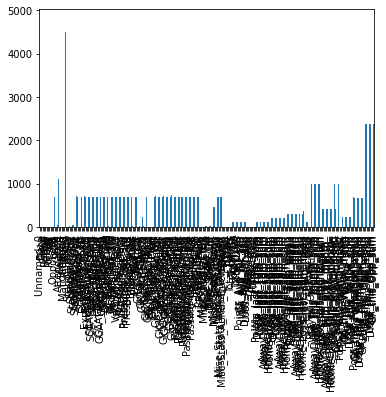

In [36]:
All_team_data.isna().sum().plot.bar()

In [43]:
all_no_stats_bomb = All_team_data[no_stats_bomb]

In [44]:
all_no_stats_bomb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4783 entries, 0 to 41
Columns: 133 entries, Date to GF_this_Opp_sum
dtypes: datetime64[ns](2), float64(99), int64(15), object(16), timedelta64[ns](1)
memory usage: 4.9+ MB


In [54]:
all_no_stats_bomb.isna().sum()[all_no_stats_bomb.isna().sum()>0].sort_values(ascending=False)

Notes                 4491
Poss_this_Opp_mean    2392
GF_this_Opp_sum       2377
GA_this_Opp_sum       2377
Draw_this_Opp_sum     2377
                      ... 
Win_Avg_for_szn        100
Poss                    31
Formation                2
Captain                  2
Referee                  1
Length: 107, dtype: int64

<AxesSubplot:>

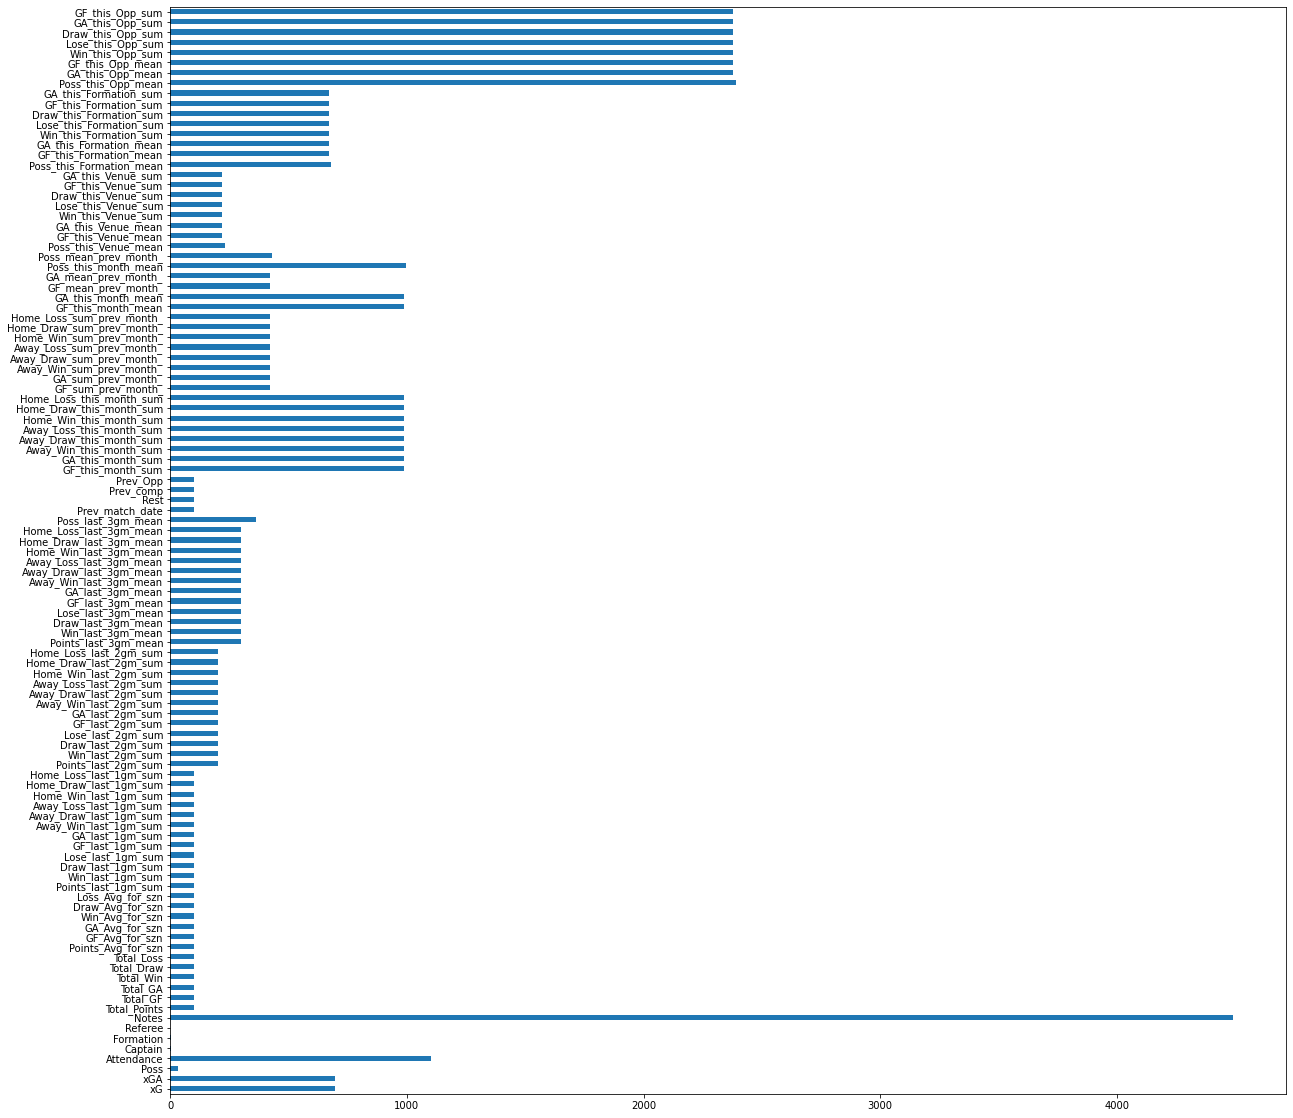

In [56]:
plt.figure(figsize=(20,20))
all_no_stats_bomb.isna().sum()[all_no_stats_bomb.isna().sum()>0].plot.barh()

In [24]:
All_team_data.to_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\All_team_data2.csv",header=True,index=False)